# Handwritten digits recognizer

This notebook develops a convolutional neural network with pytorch to identify hand written digits using MNIST database (https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png)

In [1]:
from torch.autograd import Variable

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#!pip install torch-summary
from torchsummary import summary

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

os.getcwd()

'/Users/alessandraginelli/Documents/Master/DeepLearning'

### Function to get mean and std of channels

In [2]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [3]:
trainloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()), 
    batch_size=32, shuffle=True)

get_mean_and_std(trainloader)

(tensor([0.1307]), tensor([0.3081]))

## Dataloaders

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307), (0.3081))])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(dataset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

#testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [5]:
dataset.data[0].shape

torch.Size([28, 28])

In [6]:
print("trainset length:", len(trainset), "\nvalidation set length:", len(valset))

trainset length: 50000 
validation set length: 10000


### Representation of one image 

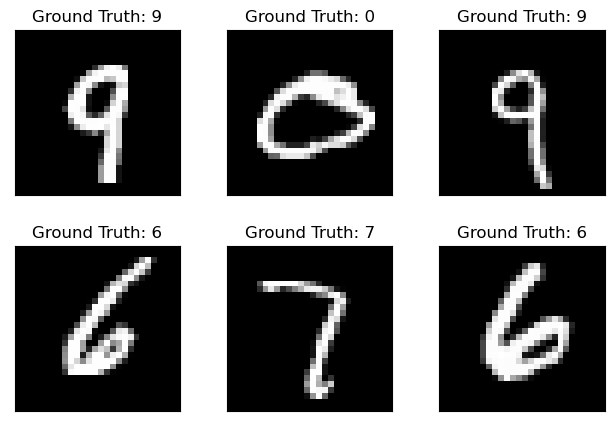

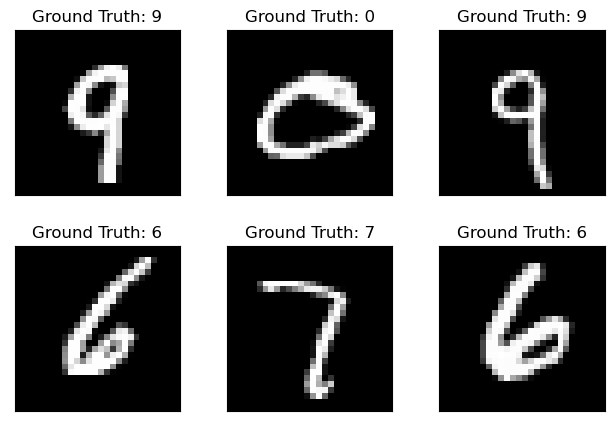

In [7]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

## Define NN class, initiate loss function and optimizer 

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1), #28+2-5+1
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1), #26-3+2+1
            nn.ReLU(inplace=True),   
            nn.MaxPool2d(kernel_size=2, stride=2),   #26/2
            nn.Conv2d(64, 96, kernel_size=3, padding=1), #13-3+2+1
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1), #13-3+2+1
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1), #13-3+2+1
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), #13-3+2+1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),  #13-2+1=12 it's the number in the fc layer
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048), #32=out_channel of the last Conv2d; 
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,10),
        )

        
    def forward(self, x):
        x = self.feature(x)
        x = x.view(-1,32*12*12) #prepare the net before applying fc
        x = self.classifier(x)
        return x

In [9]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
print(summary(net, (1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 12, 12]          --
|    └─Conv2d: 2-1                       [-1, 32, 26, 26]          832
|    └─ReLU: 2-2                         [-1, 32, 26, 26]          --
|    └─Conv2d: 2-3                       [-1, 64, 26, 26]          18,496
|    └─ReLU: 2-4                         [-1, 64, 26, 26]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 13, 13]          --
|    └─Conv2d: 2-6                       [-1, 96, 13, 13]          55,392
|    └─ReLU: 2-7                         [-1, 96, 13, 13]          --
|    └─Conv2d: 2-8                       [-1, 64, 13, 13]          55,360
|    └─ReLU: 2-9                         [-1, 64, 13, 13]          --
|    └─Conv2d: 2-10                      [-1, 32, 13, 13]          18,464
|    └─ReLU: 2-11                        [-1, 32, 13, 13]          --
|    └─Conv2d: 2-12                      [-1, 32, 13, 13]          9

## Training CNN

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------
Finished Training


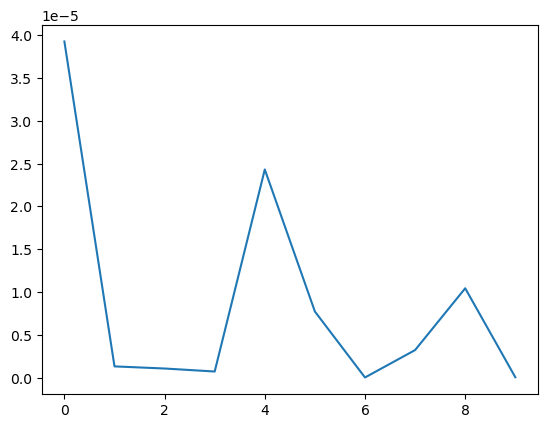

In [11]:
train_losses = []
loss_values=[]
num_epochs = 10

x_epoch = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    
    x_epoch.append(epoch)
    
    #def train(epoch):
    net.train()
    running_loss = 0.0
    
    # Iterate over data.              
    for i, (data, target) in enumerate(trainloader):
        # Get the inputs
        inputs, labels = Variable(data), Variable(target)
        #inputs = inputs.view(-1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        train_losses.append(loss.data.item())
        loss.backward()
        optimizer.step()
        
        running_loss =+ loss.item() * data.size(0)
    loss_values.append(running_loss / len(trainset))
    
plt.plot(loss_values)
        
print('Finished Training')

In [15]:
loss_values

[3.924491882324219e-05,
 1.3516578078269958e-06,
 1.1038026213645935e-06,
 7.530917227268219e-07,
 2.431663751602173e-05,
 7.749983072280885e-06,
 5.798537284135818e-08,
 3.255614936351776e-06,
 1.0459471940994262e-05,
 8.903657086193561e-08]

The lower the loss, the better the model. 
The loss is calculated on training and validation and its interpretation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

## Evaluating the results

The testing set accuracy of the network is: 99 %


Text(0, 0.5, 'percent')

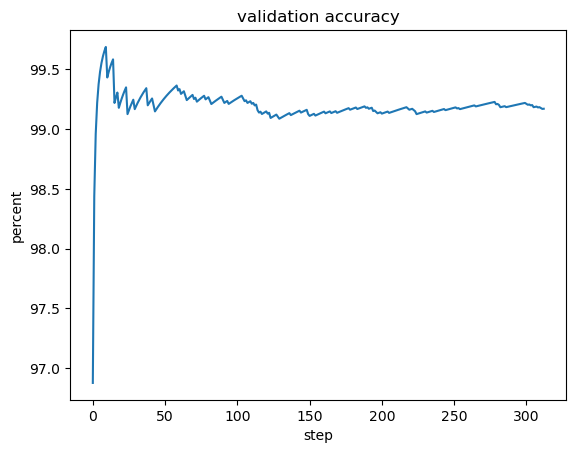

In [12]:
correct, total, accuracy = 0, 0, 0
predictions = []
accuracy_val=[]

net.eval()

for i, data in enumerate(valloader, 0):
    inputs, labels = data
    
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(outputs)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy_val.append(100 * correct / total)
    
print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

plt.figure()
plt.plot(accuracy_val)
plt.title('validation accuracy')
plt.xlabel('step')
plt.ylabel('percent')

## Evaluation on test set

The testing set accuracy of the network is: 99 %


Text(0, 0.5, 'percent')

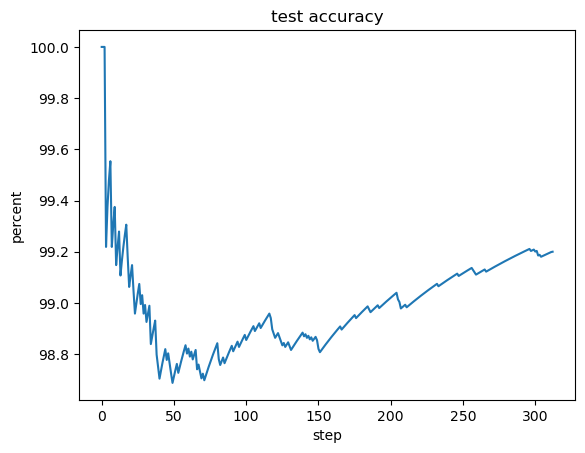

In [13]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

correct, total, accuracy = 0, 0, 0
predictions = []
accuracy_test=[]
net.eval()
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(outputs)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy_test.append(100 * correct / total)
    
print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))
    
plt.figure()
plt.plot(accuracy_test)
plt.title('test accuracy')
plt.xlabel('step')
plt.ylabel('percent')

The accuracy of a model is the number of correct predictions on the overall number of data. 
The higher the best.

## Save the model

In [14]:
# Instantiate the model
model = Net()
# Load the parameters from the old model
model.load_state_dict(torch.load('mnist_net.pth'))

<All keys matched successfully>